# Visualização de Métodos PDI

Este notebook demonstra todos os métodos de Processamento Digital de Imagens (PDI) implementados no sistema.

## Objetivo

Visualizar cada etapa do processamento de uma imagem aleatória, mostrando:
- Pré-processamento (filtros, conversão)
- Correção de iluminação (CLAHE, equalização, normalização LAB)
- Limiarização (Otsu, Adaptativo, Canny)
- Segmentação robusta (máscara e contorno)
- Operações morfológicas (abertura, fechamento, dilatação, erosão)
- Remoção de fundo (flood fill, filtragem)
- Extração de características (forma, cor, textura, gradiente)
- Resultado final (imagem segmentada com contorno)


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import sys

# Encontrar a raiz do projeto (onde está a pasta libs/)
def encontrar_raiz_projeto():
    diretorio_atual = os.path.abspath(os.getcwd())
    while diretorio_atual != os.path.dirname(diretorio_atual):
        if os.path.exists(os.path.join(diretorio_atual, 'libs')) and os.path.exists(os.path.join(diretorio_atual, 'requirements')):
            return diretorio_atual
        diretorio_atual = os.path.dirname(diretorio_atual)
    # Fallback: tentar caminho relativo
    raiz_relativa = os.path.abspath(os.path.join(os.getcwd(), '..'))
    if os.path.exists(os.path.join(raiz_relativa, 'libs')):
        return raiz_relativa
    return os.getcwd()

raiz_projeto = encontrar_raiz_projeto()
if raiz_projeto not in sys.path:
    sys.path.insert(0, raiz_projeto)

from libs import segmentation
from libs import features

plt.rcParams['figure.figsize'] = (15, 10)


In [2]:
def carregar_imagem_aleatoria():
    # Usar a raiz do projeto para encontrar os datasets
    dataset_paths = [
        os.path.join(raiz_projeto, 'dataset'),
        os.path.join(raiz_projeto, 'dataset_test')
    ]
    imagens = []
    
    for dataset_path in dataset_paths:
        if os.path.exists(dataset_path):
            for produto in os.listdir(dataset_path):
                produto_path = os.path.join(dataset_path, produto)
                if os.path.isdir(produto_path):
                    for arquivo in os.listdir(produto_path):
                        if arquivo.lower().endswith(('.jpg', '.jpeg', '.png', '.webp')):
                            imagens.append((os.path.join(produto_path, arquivo), produto))
    
    if not imagens:
        raise ValueError("Nenhuma imagem encontrada nos datasets")
    
    caminho_imagem, produto = random.choice(imagens)
    imagem = cv2.imread(caminho_imagem)
    
    if imagem is None:
        raise ValueError(f"Não foi possível carregar a imagem: {caminho_imagem}")
    
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    return imagem, produto, caminho_imagem

imagem_original, produto_nome, caminho = carregar_imagem_aleatoria()
print(f"Imagem selecionada: {caminho}")
print(f"Produto: {produto_nome}")
print(f"Dimensões: {imagem_original.shape}")


Imagem selecionada: c:\Users\Davi\Downloads\a\pdi-reconhecimento-produtos\dataset\Cocos\r_100_100.jpg
Produto: Cocos
Dimensões: (100, 100, 3)


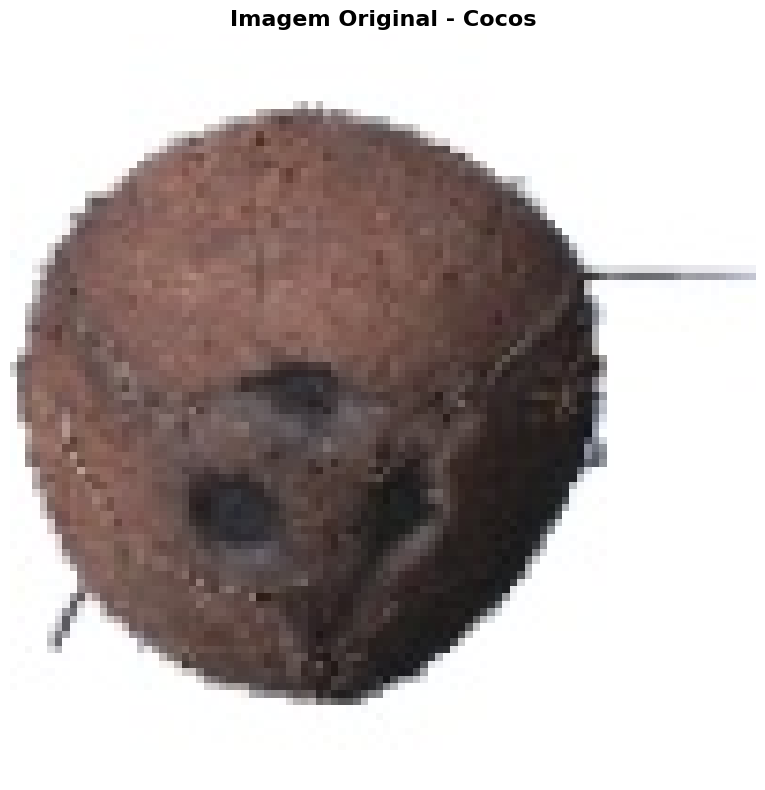

In [3]:
plt.figure(figsize=(8, 8))
plt.imshow(imagem_original)
plt.title(f'Imagem Original - {produto_nome}', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


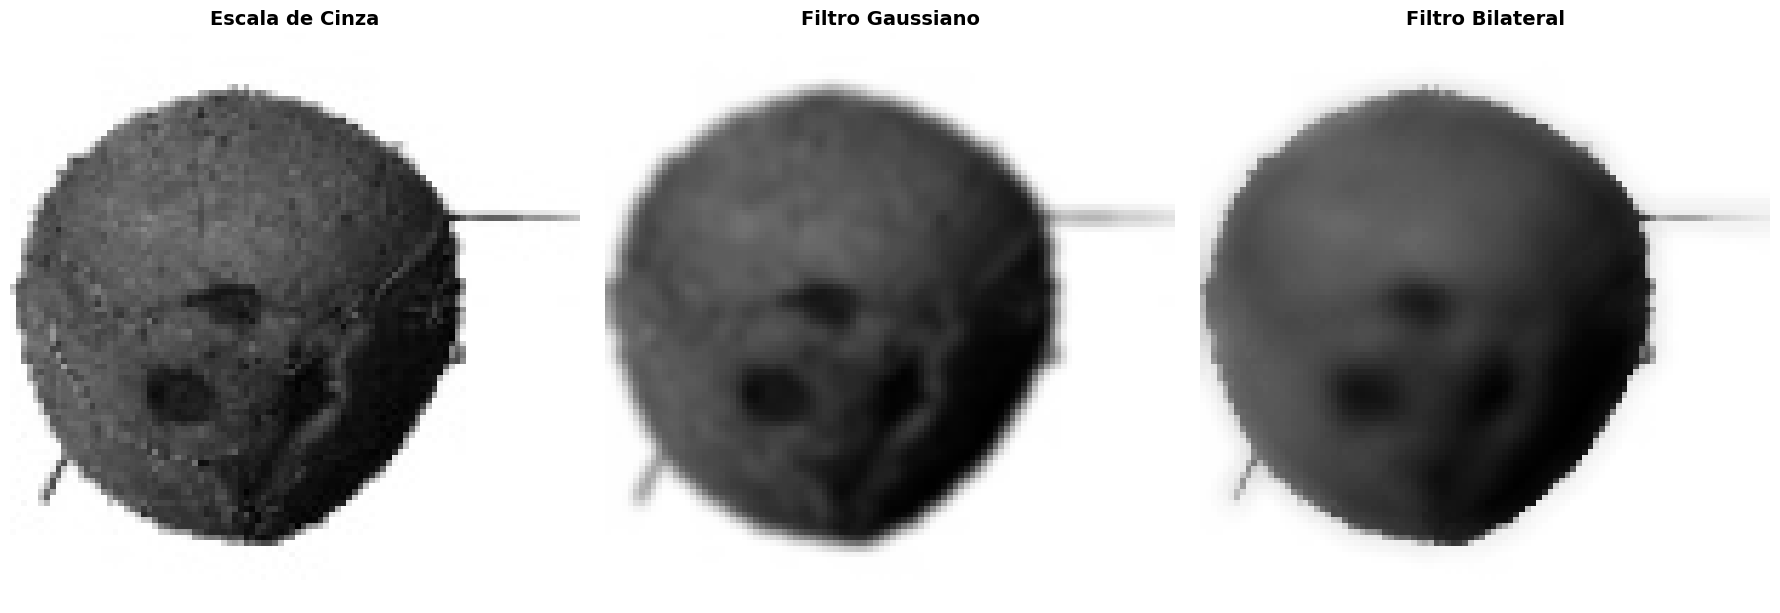

In [4]:
imagem_bgr = cv2.cvtColor(imagem_original, cv2.COLOR_RGB2BGR)
imagem_cinza = cv2.cvtColor(imagem_bgr, cv2.COLOR_BGR2GRAY)
imagem_gaussiano = segmentation.filtrar_gaussiano(imagem_cinza, ksize=5)
imagem_bilateral = segmentation.filtrar_bilateral(imagem_cinza, d=9, sigma=75)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(imagem_cinza, cmap='gray')
axes[0].set_title('Escala de Cinza', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(imagem_gaussiano, cmap='gray')
axes[1].set_title('Filtro Gaussiano', fontsize=14, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(imagem_bilateral, cmap='gray')
axes[2].set_title('Filtro Bilateral', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()


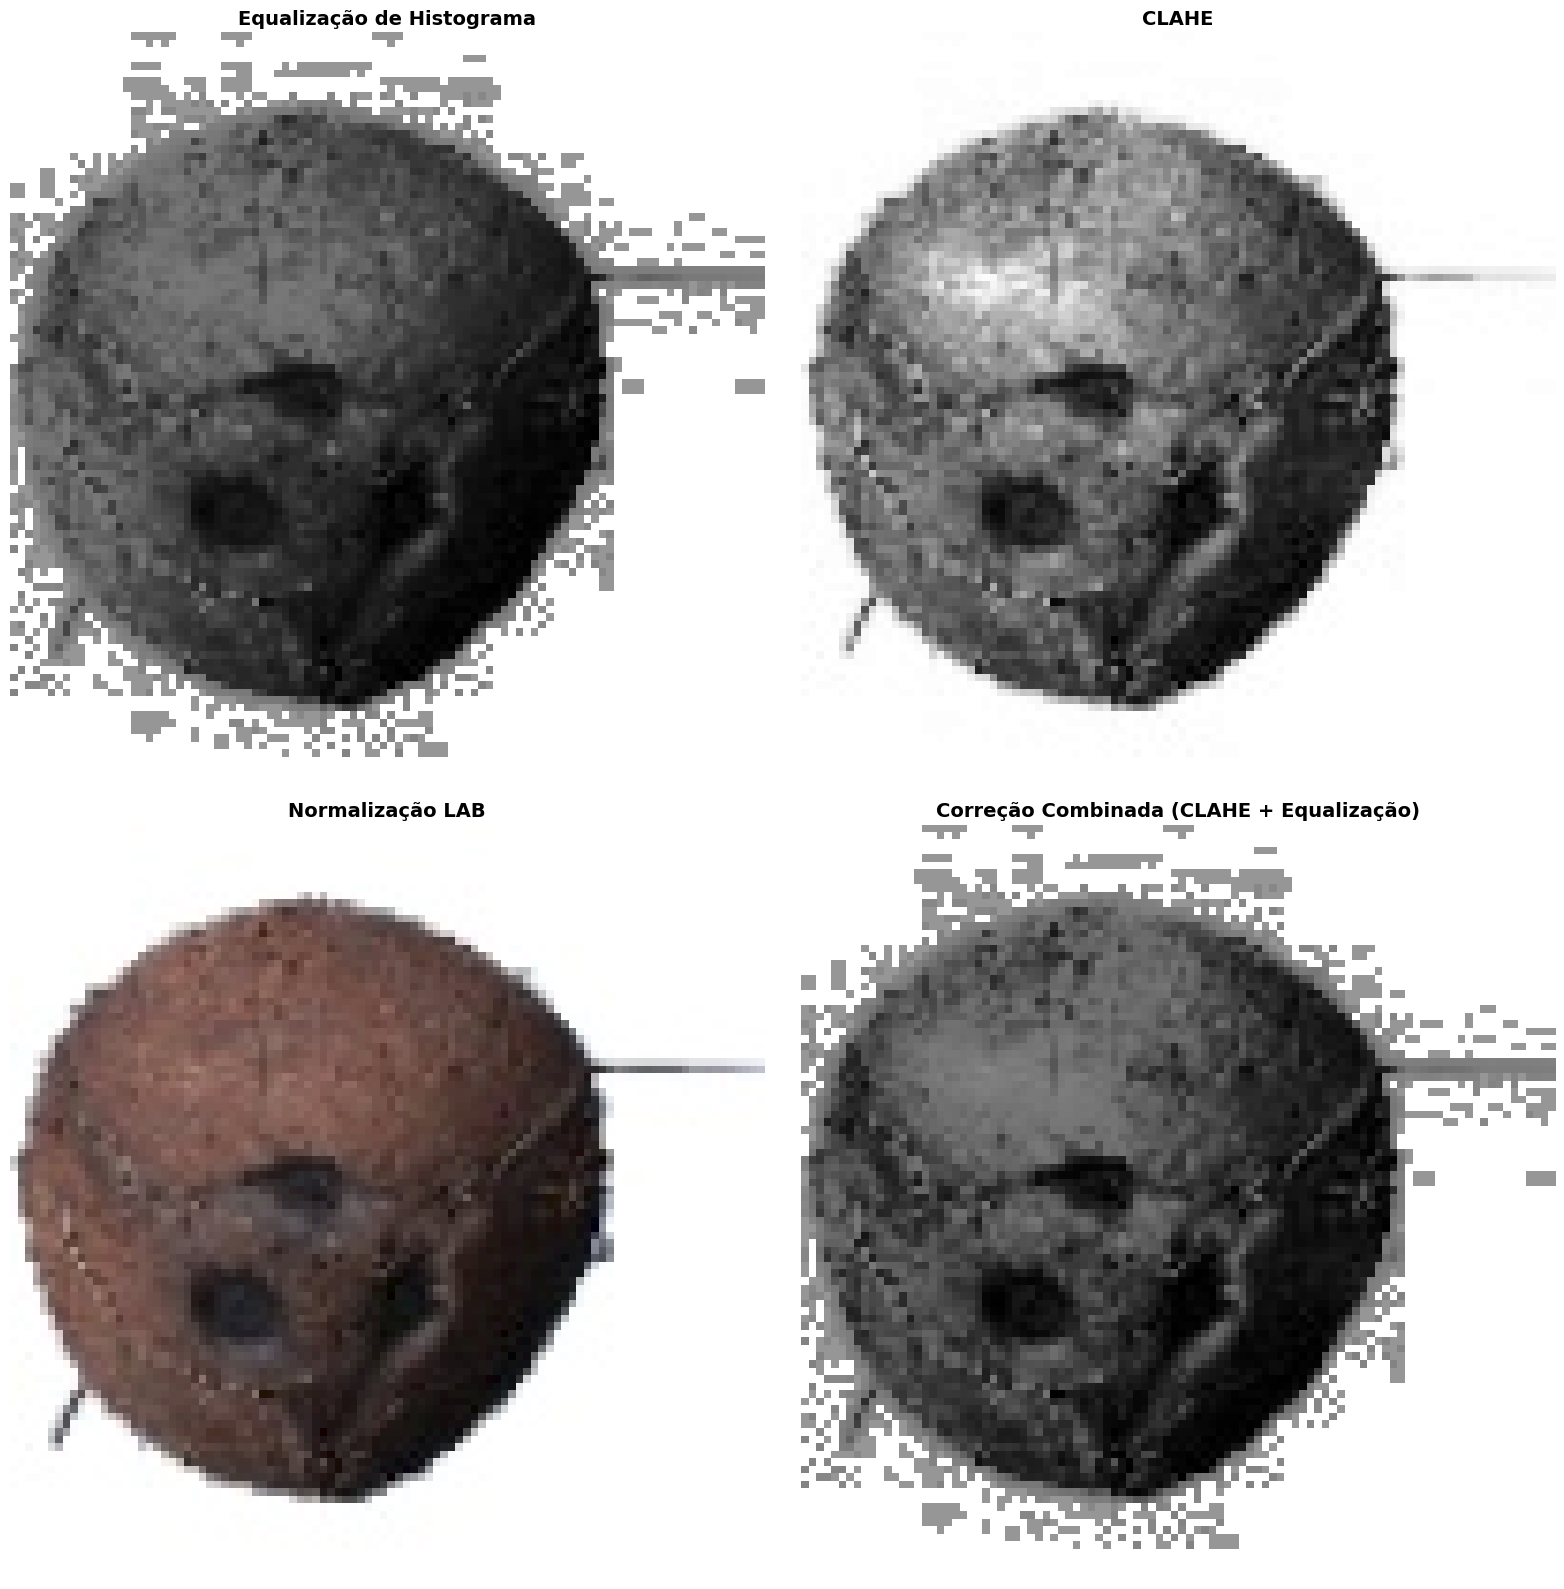

In [5]:
imagem_equalizada = segmentation.equalizar_histograma(imagem_cinza)
imagem_clahe = segmentation.clahe(imagem_cinza, clip_limit=2.0, tile_grid_size=(8, 8))
imagem_normalizada_lab = segmentation.normalizar_iluminacao(imagem_bgr)
imagem_corrigida = segmentation.corrigir_iluminacao(imagem_cinza)

if imagem_normalizada_lab is not None:
    imagem_normalizada_lab_rgb = cv2.cvtColor(imagem_normalizada_lab, cv2.COLOR_BGR2RGB)
else:
    imagem_normalizada_lab_rgb = None

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes[0, 0].imshow(imagem_equalizada, cmap='gray')
axes[0, 0].set_title('Equalização de Histograma', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(imagem_clahe, cmap='gray')
axes[0, 1].set_title('CLAHE', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

if imagem_normalizada_lab_rgb is not None:
    axes[1, 0].imshow(imagem_normalizada_lab_rgb)
    axes[1, 0].set_title('Normalização LAB', fontsize=14, fontweight='bold')
else:
    axes[1, 0].text(0.5, 0.5, 'Falha na normalização', ha='center', va='center')
    axes[1, 0].set_title('Normalização LAB', fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(imagem_corrigida, cmap='gray')
axes[1, 1].set_title('Correção Combinada (CLAHE + Equalização)', fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


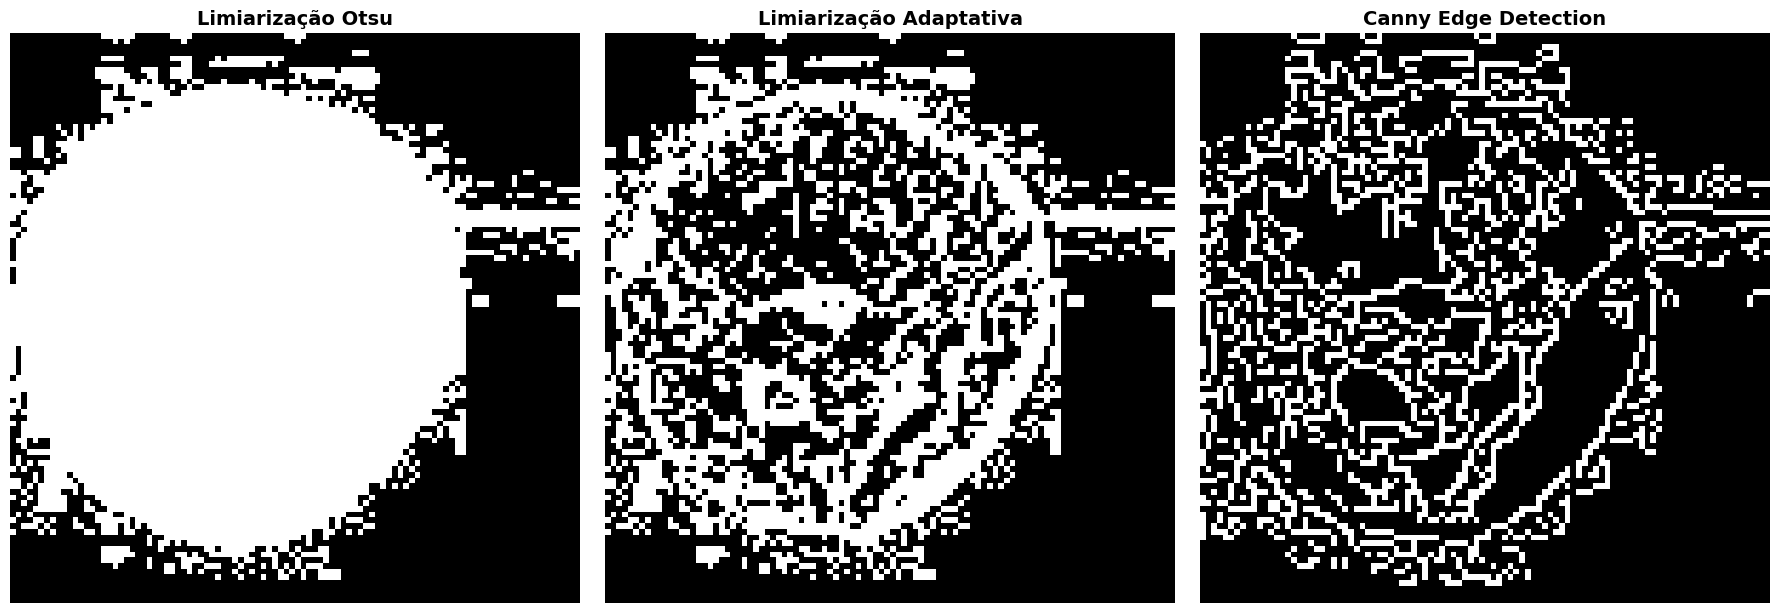

In [6]:
imagem_otsu = segmentation.limiar_otsu(imagem_corrigida)
imagem_adaptativo = segmentation.limiar_adaptativo(imagem_corrigida, metodo='gaussian', block_size=11, C=2)
imagem_canny = segmentation.limiar_canny(imagem_corrigida, low=50, high=150)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(imagem_otsu, cmap='gray')
axes[0].set_title('Limiarização Otsu', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(imagem_adaptativo, cmap='gray')
axes[1].set_title('Limiarização Adaptativa', fontsize=14, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(imagem_canny, cmap='gray')
axes[2].set_title('Canny Edge Detection', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()


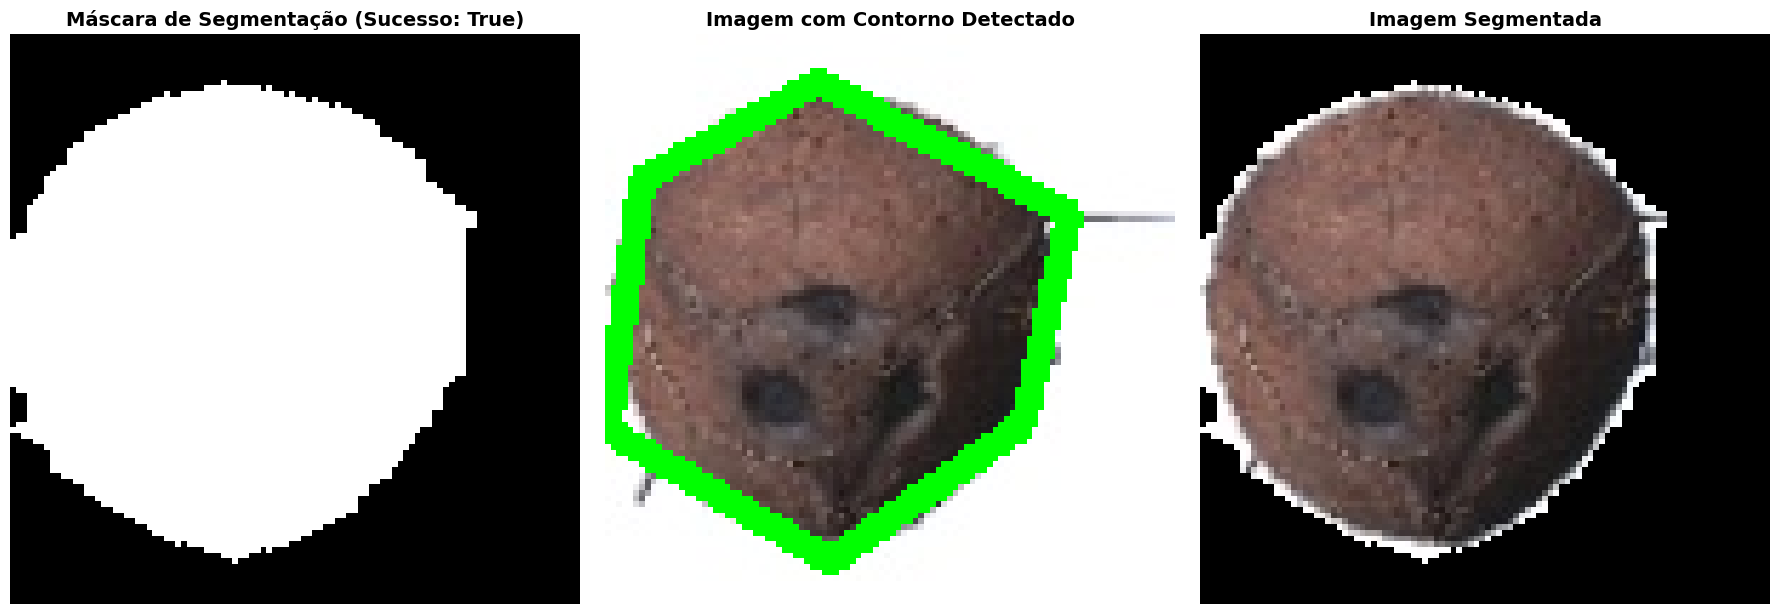

In [7]:
mascara, contorno, sucesso = segmentation.segmentar_produto_robusto(imagem_cinza, imagem_bgr)

imagem_com_contorno = imagem_original.copy()
if contorno is not None:
    contorno_rgb = contorno.copy()
    for i in range(len(contorno_rgb)):
        contorno_rgb[i][0][0] = contorno[i][0][0]
        contorno_rgb[i][0][1] = contorno[i][0][1]
    cv2.drawContours(imagem_com_contorno, [contorno_rgb], -1, (0, 255, 0), 3)

imagem_segmentada = cv2.bitwise_and(imagem_original, imagem_original, mask=mascara)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(mascara, cmap='gray')
axes[0].set_title(f'Máscara de Segmentação (Sucesso: {sucesso})', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(imagem_com_contorno)
axes[1].set_title('Imagem com Contorno Detectado', fontsize=14, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(imagem_segmentada)
axes[2].set_title('Imagem Segmentada', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()


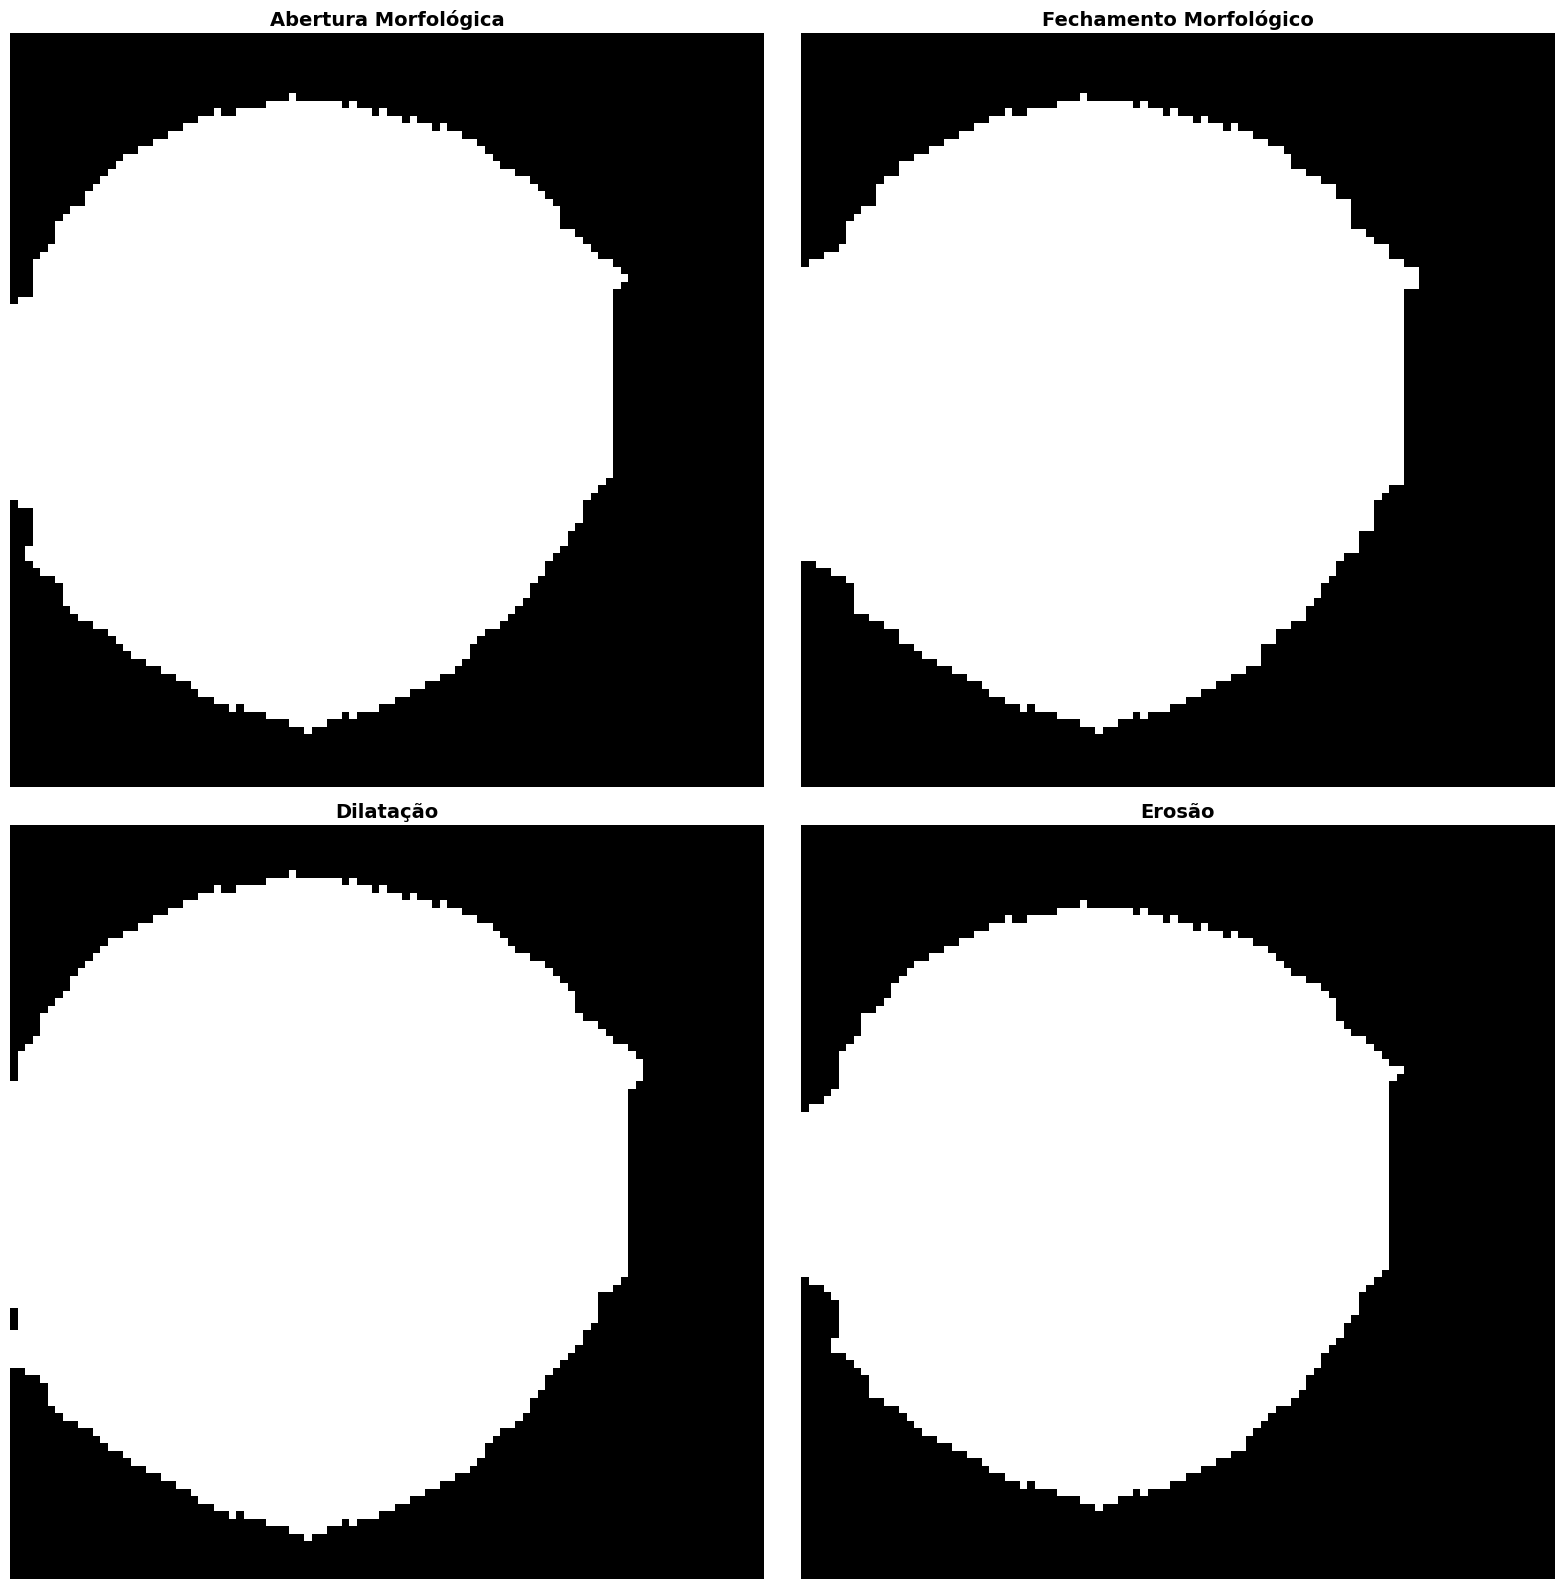

In [8]:
mascara_abertura = segmentation.abertura(mascara, kernel_size=3, iterations=2)
mascara_fechamento = segmentation.fechamento(mascara, kernel_size=5, iterations=2)
mascara_dilatacao = segmentation.dilatacao(mascara, kernel_size=3, iterations=2)
mascara_erosao = segmentation.erosao(mascara, kernel_size=3, iterations=2)

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes[0, 0].imshow(mascara_abertura, cmap='gray')
axes[0, 0].set_title('Abertura Morfológica', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(mascara_fechamento, cmap='gray')
axes[0, 1].set_title('Fechamento Morfológico', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

axes[1, 0].imshow(mascara_dilatacao, cmap='gray')
axes[1, 0].set_title('Dilatação', fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(mascara_erosao, cmap='gray')
axes[1, 1].set_title('Erosão', fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


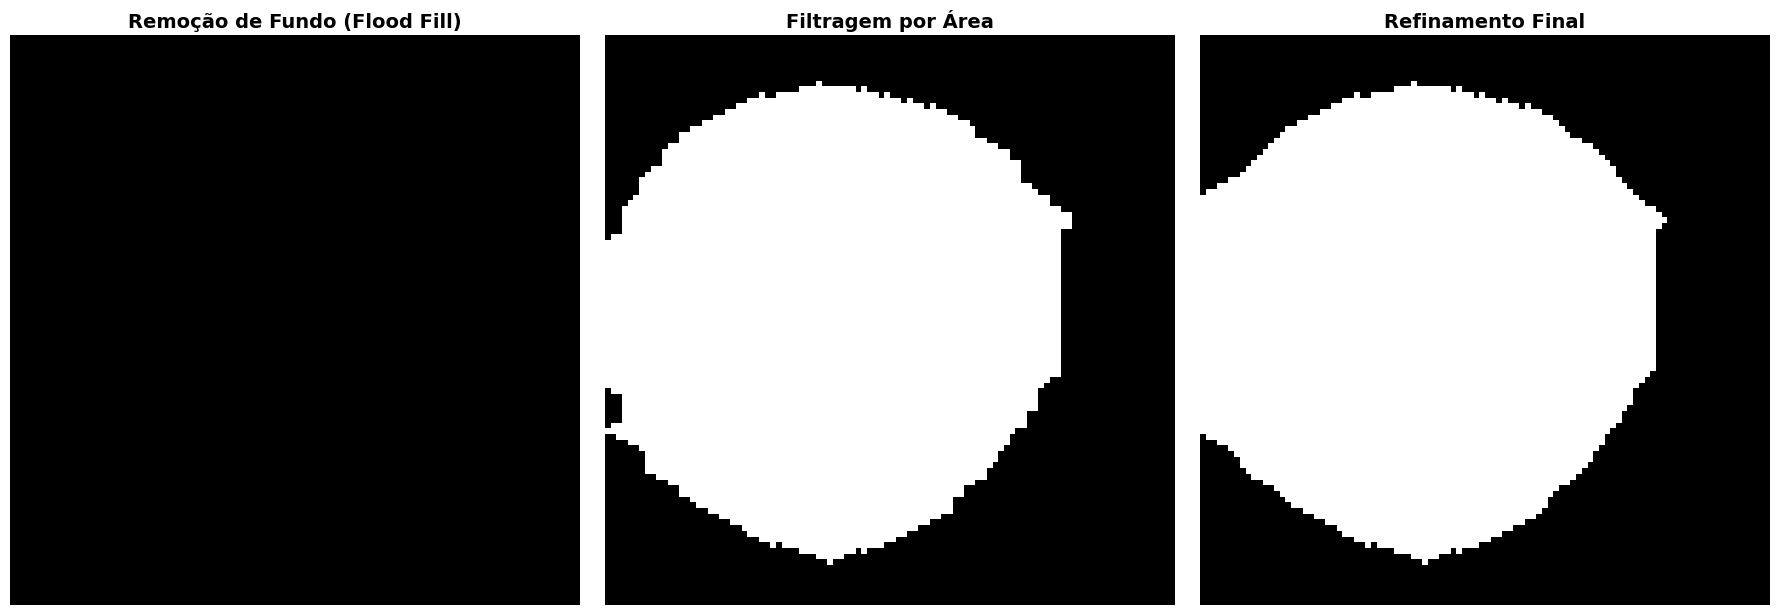

In [9]:
mascara_sem_fundo = segmentation.remover_fundo_bordas(mascara.copy())
mascara_filtrada = segmentation.filtrar_por_area(mascara, frac_min=0.01)
mascara_refinada = segmentation.refinar_segmentacao(mascara)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(mascara_sem_fundo, cmap='gray')
axes[0].set_title('Remoção de Fundo (Flood Fill)', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(mascara_filtrada, cmap='gray')
axes[1].set_title('Filtragem por Área', fontsize=14, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(mascara_refinada, cmap='gray')
axes[2].set_title('Refinamento Final', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()


In [10]:
if contorno is not None and mascara is not None:
    imagem_segmentada_cinza = cv2.bitwise_and(imagem_cinza, imagem_cinza, mask=mascara)
    
    caracteristicas = features.extrair_todas_caracteristicas(
        imagem_segmentada_cinza, 
        contorno, 
        imagem_bgr, 
        mascara
    )
    
    print("=" * 60)
    print("CARACTERÍSTICAS EXTRAÍDAS")
    print("=" * 60)
    
    print("\n--- FORMA (8 características) ---")
    forma = caracteristicas.get('forma', {})
    print(f"Área: {forma.get('area', 0):.2f}")
    print(f"Perímetro: {forma.get('perimetro', 0):.2f}")
    print(f"Circularidade: {forma.get('circularidade', 0):.4f}")
    print(f"Aspect Ratio: {forma.get('aspect_ratio', 0):.4f}")
    print(f"Extent: {forma.get('extent', 0):.4f}")
    print(f"Solidity: {forma.get('solidity', 0):.4f}")
    print(f"Eccentricity: {forma.get('eccentricity', 0):.4f}")
    print(f"Compactness: {forma.get('compactness', 0):.4f}")
    
    print("\n--- COR (14 características) ---")
    cor = caracteristicas.get('cor', {})
    print(f"RGB Média - R: {cor.get('cor_media_r', 0):.4f}, G: {cor.get('cor_media_g', 0):.4f}, B: {cor.get('cor_media_b', 0):.4f}")
    print(f"RGB Std - R: {cor.get('cor_std_r', 0):.4f}, G: {cor.get('cor_std_g', 0):.4f}, B: {cor.get('cor_std_b', 0):.4f}")
    print(f"HSV Média - H: {cor.get('hsv_media_h', 0):.4f}, S: {cor.get('hsv_media_s', 0):.4f}, V: {cor.get('hsv_media_v', 0):.4f}")
    print(f"HSV Std - H: {cor.get('hsv_std_h', 0):.4f}, S: {cor.get('hsv_std_s', 0):.4f}, V: {cor.get('hsv_std_v', 0):.4f}")
    
    print("\n--- TEXTURA (5 características) ---")
    textura = caracteristicas.get('textura', {})
    print(f"LBP Média: {textura.get('lbp_media', 0):.4f}")
    print(f"LBP Desvio: {textura.get('lbp_desvio', 0):.4f}")
    print(f"GLCM Contrast: {textura.get('glcm_contrast', 0):.4f}")
    print(f"GLCM Energy: {textura.get('glcm_energy', 0):.4f}")
    print(f"GLCM Homogeneity: {textura.get('glcm_homogeneity', 0):.4f}")
    
    print("\n--- GRADIENTE (3 características) ---")
    gradiente = caracteristicas.get('gradiente', {})
    print(f"Sobel Média: {gradiente.get('hog_media', 0):.4f}")
    print(f"Sobel Desvio: {gradiente.get('hog_desvio', 0):.4f}")
    print(f"Sobel Máximo: {gradiente.get('hog_max', 0):.4f}")
    
    vetor = features.criar_vetor_caracteristicas(caracteristicas)
    if vetor is not None:
        print(f"\n--- VETOR FINAL ---")
        print(f"Dimensões: {len(vetor)}")
        print(f"Primeiros 5 valores: {vetor[:5]}")
        print(f"Últimos 5 valores: {vetor[-5:]}")
else:
    print("Não foi possível extrair características - segmentação falhou")


CARACTERÍSTICAS EXTRAÍDAS

--- FORMA (8 características) ---
Área: 4604.00
Perímetro: 254.16
Circularidade: 0.8956
Aspect Ratio: 0.9647
Extent: 0.6605
Solidity: 1.0000
Eccentricity: 0.4906
Compactness: 1.1165

--- COR (14 características) ---
RGB Média - R: 0.5324, G: 0.4533, B: 0.4386
RGB Std - R: 0.2360, G: 0.2231, B: 0.2217
HSV Média - H: 0.1609, S: 0.1888, V: 0.5337
HSV Std - H: 0.3022, S: 0.0944, V: 0.2363

--- TEXTURA (5 características) ---
LBP Média: 0.1000
LBP Desvio: 0.1443
GLCM Contrast: 1191.2996
GLCM Energy: 0.4667
GLCM Homogeneity: 0.5414

--- GRADIENTE (3 características) ---
Sobel Média: 84.6919
Sobel Desvio: 194.5465
Sobel Máximo: 1139.9482

--- VETOR FINAL ---
Dimensões: 30
Primeiros 5 valores: [1.00000000e+00 5.51036070e-02 8.79928129e-05 1.02997713e-04
 3.69262314e-05]
Últimos 5 valores: [3.07855644e-04 3.70585039e-04 0.00000000e+00 1.04102238e-01
 1.00000000e+00]


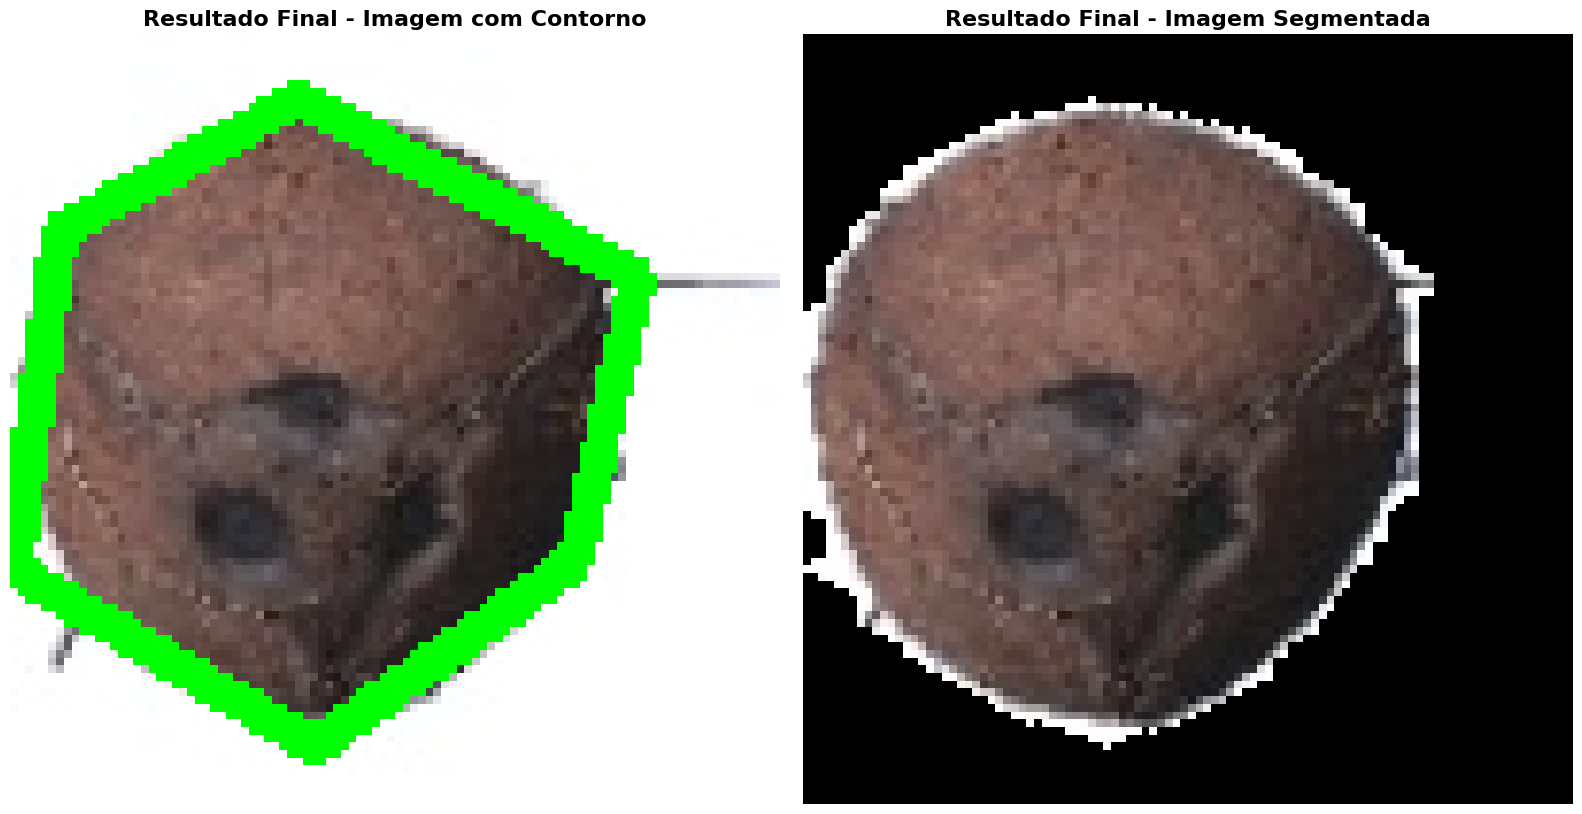


✓ Processamento concluído com sucesso!
✓ Produto: Cocos
✓ Segmentação: Sucesso


In [11]:
if contorno is not None and mascara is not None:
    imagem_final = imagem_original.copy()
    contorno_rgb = contorno.copy()
    for i in range(len(contorno_rgb)):
        contorno_rgb[i][0][0] = contorno[i][0][0]
        contorno_rgb[i][0][1] = contorno[i][0][1]
    cv2.drawContours(imagem_final, [contorno_rgb], -1, (0, 255, 0), 3)
    
    imagem_segmentada_final = cv2.bitwise_and(imagem_original, imagem_original, mask=mascara)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].imshow(imagem_final)
    axes[0].set_title('Resultado Final - Imagem com Contorno', fontsize=16, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(imagem_segmentada_final)
    axes[1].set_title('Resultado Final - Imagem Segmentada', fontsize=16, fontweight='bold')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Processamento concluído com sucesso!")
    print(f"✓ Produto: {produto_nome}")
    print(f"✓ Segmentação: {'Sucesso' if sucesso else 'Falha'}")
else:
    print("✗ Falha na segmentação - não foi possível gerar visualização final")
